In [4]:
from ads_api import fb_ad_api
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import ast
import json
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
#some additions to the stopwords set


In [5]:
ad_results = fb_ad_api()
#call the API and get 10 pages of 100 results each
ad_results.call_api(page_limit=100)
ad_df = ad_results.make_df()

Pulling page:1
Pulling page:2
Pulling page:3
Pulling page:4
Pulling page:5
Pulling page:6
Pulling page:7
Pulling page:8
Pulling page:9
Pulling page:10
Pulling page:11
Pulling page:12
Pulling page:13
Pulling page:14
Pulling page:15
Pulling page:16
Pulling page:17
Pulling page:18
Pulling page:19
Pulling page:20
Pulling page:21
Pulling page:22
Pulling page:23
Pulling page:24
Pulling page:25
Pulling page:26
Pulling page:27
Pulling page:28
Pulling page:29
Pulling page:30
Pulling page:31
Pulling page:32
Pulling page:33
Pulling page:34
Pulling page:35
Pulling page:36
Pulling page:37
Pulling page:38
Pulling page:39
Pulling page:40
Pulling page:41
Pulling page:42
Pulling page:43
Pulling page:44
Pulling page:45
Pulling page:46
Pulling page:47
Pulling page:48
Pulling page:49
Pulling page:50
Pulling page:51
Pulling page:52
Pulling page:53
Pulling page:54
Pulling page:55
Pulling page:56
Pulling page:57
Pulling page:58
Pulling page:59
Pulling page:60
Pulling page:61
Pulling page:62
Pulling page:63
P

In [6]:
# change upper/lower bound data entries to just upper_bound value
def remove_dict(sample):
    sample_dict = ast.literal_eval(str(sample))
    return sample_dict['upper_bound']
ad_df['Impressions'] = ad_df['Impressions'].map(remove_dict)
ad_df['AdSpending'] = ad_df['AdSpending'].map(remove_dict)

In [7]:
# list of ML features to reference
ad_features = ['positivity','toxicity','identityAttack', 'insult']
#padding function

def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

#function to return a ML prediction from text
def sample_predict(sample_pred_text):
    #encode sample
    encoded_sample_pred_text = tokenizer.encode(sample_pred_text) 
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

# mapping function for the 
def binary_label(prediction):
    if prediction >= 0.5:
        return 1
    return 0

In [8]:
#loop for each of the ad feature models
for feature in ad_features:
    print(f'processing {feature}')
    #set specific tokenizer if doing positivity predictions
    if feature == 'positivity':
        tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file('../ml_settings/positivity_large_tokenizer')
    else:
        tokenizer = tfds.features.text.SubwordTextEncoder.load_from_file('../ml_settings/large_tokenizer')
    #load model
    model = tf.keras.models.load_model(f'../ml_settings/{feature}_rnn.h5')

    #map predictions to new column
    ad_df[feature] = ad_df['AdText'].map(lambda x: binary_label(sample_predict(str(x))))
    

processing positivity


processing toxicity


processing identityAttack


processing insult


In [14]:
ad_df['dummy_id'] = range(1, len(ad_df) + 1)
ad_df.loc[ad_df['dummy_id']==2200,:]

,AdID,AdURL,AdText,HostedPage,Impressions,Currency,AdSpending,positivity,toxicity,identityAttack,insult,dummy_id
2199,862396234281895,https://www.facebook.com/ads/archive/render_ad...,You can vote safely on or by June 9 by request...,Dakota Leadership PAC,999,USD,99,0,0,0,0,2200


In [13]:
#save resultin dfs to csv. save a unique df with duplicates removed as well
ad_df.to_csv('../Data/20200528.csv')
# unique_ad_df = ad_df.drop_duplicates(subset = 'AdText', keep='first')
# unique_ad_df.to_csv('../Data/2020514unique.csv')

In [32]:
#read dataframes from csv if restarting notebook
ad_df = pd.read_csv('../Data/20200528.csv')
unique_ad_df = pd.read_csv('../Data/2020514unique.csv')

In [92]:
ad_features = ['positivity','toxicity', 'insult', 'general']

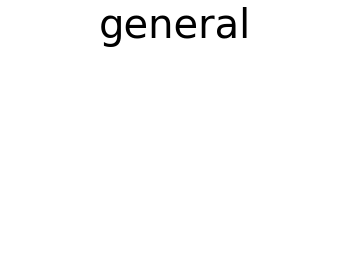

In [93]:
# Wordcloud for most common words in positively labeled ads
for word_cloud_feature in ad_features:
    
    if word_cloud_feature == 'general': #select the whole df for the 'general' feature
        df = ad_df['AdText']
    else:
        cloud_text = ad_df.loc[ad_df[word_cloud_feature]==1, 'AdText'] #select entries positive for feature
        
    if len(cloud_text) > 0: #only proceed if there is actual text that was labeled positive
        word_cloud_fig = WordCloud(
                                stopwords=STOPWORDS,
                                background_color='black',
                                collocations=False,
                                width=2500,
                                height=1800
                                ).generate(" ".join(cloud_text))

        plt.axis('off')
        plt.title(word_cloud_feature,fontsize=40)
        word_cloud_fig.to_file('{}.jpg'.format(word_cloud_feature))

In [119]:
#function for generating dictionaries of top words for graphing

def top_words(unique=False):
    STOPWORDS.add('\n\nHe')
    output_to_js = {}
    
    #set to df with duplicates by default. If unique == True then use df without duplicates
    df = ad_df
    if unique == True:
        df = unique_ad_df
    
    #loop through ad features to identify top words
    for feature in ad_features:
        
        if word_cloud_feature == 'general': #select the whole df for the 'general' feature
            text = df['AdText']
        else:
            text = df.loc[ad_df[word_cloud_feature]==1, 'AdText'] #select entries positive for feature
        
        #join all ad text into single string then split by spaces into list
        text = " ".join(str(description) for description in text).split(' ')

        #remove stopwords
        text = [word for word in text if not word in STOPWORDS]

        #use counter to grab most common words
        count_tuple = Counter(text).most_common(10)

        #write counts to dictionary
        count_dict = {}
        for entry in count_tuple:
            word, count = entry
            count_dict.update({word: count})
        
        
        words_key = f'{feature}TopWords'
        if unique == True:
            words_key = f'Unique{feature}TopWords'
        
        #append the dictionary with count_dict
        output_to_js.update({words_key : count_dict})
    return(output_to_js)
    #write json into .js for static loading onto page
#     with open('../topwords.js', 'w') as outfile:
#         json.dump(output_to_js, outfile)

In [121]:
# run the function
top_words(unique=True)

{'UniquepositivityTopWords': {'need': 365,
  'We': 362,
  'help': 329,
  'County': 319,
  'us': 290,
  'de': 268,
  'Trump': 252,
  'vote': 251,
  'time': 243,
  'May': 233},
 'UniquetoxicityTopWords': {'need': 365,
  'We': 362,
  'help': 329,
  'County': 319,
  'us': 290,
  'de': 268,
  'Trump': 252,
  'vote': 251,
  'time': 243,
  'May': 233},
 'UniqueinsultTopWords': {'need': 365,
  'We': 362,
  'help': 329,
  'County': 319,
  'us': 290,
  'de': 268,
  'Trump': 252,
  'vote': 251,
  'time': 243,
  'May': 233},
 'UniquegeneralTopWords': {'need': 365,
  'We': 362,
  'help': 329,
  'County': 319,
  'us': 290,
  'de': 268,
  'Trump': 252,
  'vote': 251,
  'time': 243,
  'May': 233}}

In [122]:
def spending_values(unique=False):
    
    #empty dict for writing json output
    output_to_js = {}
    
    #set to df with duplicates by default. If unique == True then use df without duplicates
    df = ad_df
    if unique == True:
        df = unique_ad_df
        
    #loop through features in ad_features    
    for feature in ad_features:
        
        if feature == 'general': #select the whole df for the 'general' feature
            spending_series = df['AdSpending']
        else:
            spending_series = df.loc[ad_df[feature]==1, 'AdSpending'] #select only entries positive for feature
        
        
        # create dict for spending amount categories
        spending_dict = spending_series.value_counts().sort_values(ascending=False).to_dict()
        
        spending_key = f'{feature}spending'
        if unique == True:
            spending_key = f'Unique{feature}spending'
        
        output_to_js.update({spending_key: spending_dict})
    return output_to_js
    #write json into .js for static loading onto page
#     with open('../adSpending.js', 'w') as outfile:
#         json.dump(output_to_js, outfile)

In [123]:
spending_values()

{'positivityspending': {99: 3958,
  199: 36,
  299: 17,
  399: 3,
  499: 2,
  599: 2,
  999: 1,
  1999: 1},
 'toxicityspending': {99: 571, 199: 14, 399: 2},
 'insultspending': {99: 1438,
  199: 19,
  399: 6,
  299: 4,
  499: 1,
  599: 1,
  1999: 1},
 'generalspending': {99: 9601,
  199: 202,
  299: 79,
  399: 45,
  499: 13,
  699: 13,
  599: 13,
  1499: 10,
  999: 6,
  899: 5,
  2499: 3,
  799: 3,
  1999: 3,
  2999: 2,
  4499: 1,
  6999: 1}}

In [124]:
def impressions_values(unique=False):
    
    #empty dict for writing json output
    output_to_js = {}
    
    #set to df with duplicates by default. If unique == True then use df without duplicates
    df = ad_df
    if unique == True:
        df = unique_ad_df
        
    #loop through features in ad_features    
    for feature in ad_features:
        
        if feature == 'general': #select the whole df for the 'general' feature
            impressions_series = df['Impressions']
        else:
            impressions_series = df.loc[ad_df[feature]==1, 'Impressions'] #select only entries positive for feature
        
        
        # create dict for spending amount categories
        impressions_dict = impressions_series.value_counts().sort_values(ascending=False).to_dict()
        
        impressions_key = f'{feature}Impressions'
        if unique == True:
            impressions_key = f'Unique{feature}Impressions'
        
        output_to_js.update({impressions_key: impressions_dict})
    return output_to_js

In [125]:
impressions_values()

{'positivityImpressions': {999: 3264,
  1999: 340,
  2999: 136,
  3999: 86,
  4999: 43,
  5999: 33,
  14999: 31,
  6999: 18,
  7999: 13,
  19999: 13,
  8999: 10,
  9999: 9,
  24999: 8,
  39999: 6,
  29999: 4,
  34999: 3,
  124999: 2,
  44999: 1},
 'toxicityImpressions': {999: 470,
  1999: 50,
  2999: 29,
  3999: 15,
  4999: 8,
  14999: 3,
  5999: 3,
  8999: 2,
  7999: 2,
  6999: 2,
  39999: 1,
  69999: 1,
  9999: 1},
 'insultImpressions': {999: 1173,
  1999: 129,
  2999: 51,
  3999: 34,
  5999: 15,
  4999: 13,
  6999: 10,
  14999: 9,
  19999: 7,
  9999: 6,
  7999: 5,
  8999: 5,
  39999: 4,
  29999: 2,
  24999: 2,
  34999: 1,
  49999: 1,
  59999: 1,
  69999: 1,
  124999: 1},
 'generalImpressions': {999: 7741,
  1999: 920,
  2999: 335,
  3999: 223,
  5999: 123,
  14999: 123,
  4999: 120,
  6999: 67,
  7999: 62,
  19999: 49,
  8999: 48,
  24999: 43,
  9999: 32,
  29999: 27,
  39999: 17,
  34999: 15,
  44999: 8,
  59999: 7,
  69999: 6,
  124999: 5,
  174999: 5,
  149999: 5,
  49999: 4,
  7

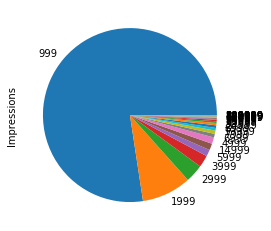

In [110]:
#plotting averages

ad_df['Impressions'].value_counts().sort_values(ascending=False).plot.pie()